# Overview of Solvers II

## Goal
- Get an overview of various solvers in Ocean
- Understand the main purpose of each solver
- Get familiar with some basic solver parameters
- Get familiar with embedding

## Problem
To focus on sampler, we are going to create a simple BQM problem that we will solve using different solvers.

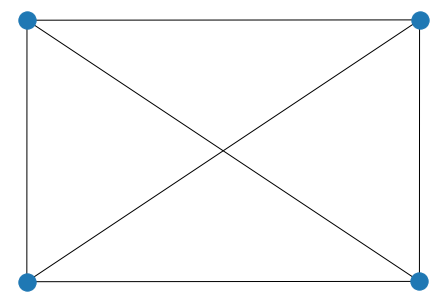

In [7]:
from dimod import AdjVectorBQM
bqm = AdjVectorBQM('SPIN')
bqm.add_variable(0, -1)
bqm.add_variable(1, -1)
bqm.add_variable(4, -1)
bqm.add_variable(5, -1)
bqm.add_interaction(0, 4, 1.0)
bqm.add_interaction(0, 5, 1.0)
bqm.add_interaction(1, 4, 1.0)
bqm.add_interaction(1, 5, 1.0)
bqm.add_interaction(0, 1, 1.0)
bqm.add_interaction(4, 5, 1.0)

import networkx as nx

nx.draw(bqm.to_networkx_graph())

## ExactSolver
- Mainly for debugging purposes
- Can solve problems with up to 20 variables (or more) depending on the system

In [8]:
from dimod import ExactSolver

solver = ExactSolver()
response = solver.sample(bqm)
print(response.truncate(10))

   0  1  4  5 energy num_oc.
0 +1 +1 -1 -1   -2.0       1
1 -1 +1 +1 -1   -2.0       1
2 +1 +1 +1 -1   -2.0       1
3 +1 -1 +1 -1   -2.0       1
4 -1 -1 +1 +1   -2.0       1
5 +1 -1 +1 +1   -2.0       1
6 -1 +1 +1 +1   -2.0       1
7 -1 +1 -1 +1   -2.0       1
8 +1 +1 -1 +1   -2.0       1
9 +1 -1 -1 +1   -2.0       1
['SPIN', 10 rows, 10 samples, 4 variables]


## DWaveSampler
- The main interface to use the quantum annealing processor
- It can select different quantum processors including the most recent Advantage system
- It can solve optimization problems casted as an Ising Hamiltonian
- The solver API allow submitting more abstract problems forms such as QUBO and BQM

In [9]:
from dwave.system import DWaveSampler

sampler = DWaveSampler()

response = sampler.sample(
    bqm, num_reads=10,
    annealing_time=10,
    auto_scale=False,
    answer_mode='raw'
    )
print(response)

BinaryQuadraticModelStructureError: Problem graph incompatible with solver.

## What happened?
- The graph of qubit connectivity is not fully connect. 
- Some qubit-qubit interactions do not exist
- If the problem graph has interactions that don't exist, we cannot solve that problem directly
- What should we do?

## EmbeddingComposite
- As mentioned above, the graph of a problem and the processor may not be compatible
- One may use a chain of qubits that are strongly connect to act as a single qubit
- This is a complicated process that requires it's own hour of lecture
- The `EmbeddingComposite` abstracts away all the complications

In [10]:
from dwave.system import EmbeddingComposite
from dwave.system import DWaveSampler

sampler = EmbeddingComposite(DWaveSampler())

response = sampler.sample(
    bqm, num_reads=10,
    annealing_time=10,
    auto_scale=True,
    answer_mode='raw',
    return_embedding=True
    )
print(response)

   0  1  4  5 energy num_oc. chain_.
0 -1 +1 +1 -1   -2.0       1     0.0
1 -1 +1 +1 +1   -2.0       1     0.0
2 +1 +1 +1 -1   -2.0       1     0.0
3 -1 +1 +1 +1   -2.0       1     0.0
4 +1 -1 +1 -1   -2.0       1     0.0
5 +1 -1 +1 -1   -2.0       1     0.0
6 +1 +1 -1 -1   -2.0       1     0.0
7 +1 -1 -1 +1   -2.0       1     0.0
8 +1 +1 -1 -1   -2.0       1     0.0
9 -1 -1 +1 +1   -2.0       1     0.0
['SPIN', 10 rows, 10 samples, 4 variables]


In [15]:
print(response.info.get('embedding_context').get('embedding'))

{0: (1964, 1960), 1: (1966,), 4: (1962, 1965), 5: (1963,)}


## DWaveCliqueSampler
- More abstractions
- If you have a dense or fully connected problem, it's much better to use a clique sampler than heuristic embedding
- Even more abstraction $\rightarrow$ no need to instantiate a sampler

In [5]:
from dwave.system import DWaveCliqueSampler

sampler = DWaveCliqueSampler()

response = sampler.sample(
    bqm, num_reads=10,
    annealing_time=10,
    answer_mode='raw'
    )
print(response)

   0  1  4  5 energy num_oc. chain_.
0 -1 -1 +1 +1   -2.0       1     0.0
1 +1 -1 -1 +1   -2.0       1     0.0
2 +1 -1 +1 -1   -2.0       1     0.0
3 +1 -1 +1 -1   -2.0       1     0.0
4 +1 +1 -1 -1   -2.0       1     0.0
5 +1 -1 -1 +1   -2.0       1     0.0
6 -1 +1 +1 -1   -2.0       1     0.0
7 -1 -1 +1 +1   -2.0       1     0.0
8 +1 +1 -1 -1   -2.0       1     0.0
9 -1 +1 -1 +1   -2.0       1     0.0
['SPIN', 10 rows, 10 samples, 4 variables]


In [6]:
from dwave.system import LeapHybridSampler

sampler = LeapHybridSampler()
print(sampler.properties)

response = sampler.sample(
    bqm, time_limit=10,
    )
print(response)

{'minimum_time_limit': [[1, 3.0], [1024, 3.0], [4096, 10.0], [10000, 40.0], [30000, 200.0], [100000, 600.0], [1000000, 600.0]], 'maximum_time_limit_hrs': 24.0, 'maximum_number_of_variables': 1000000, 'maximum_number_of_biases': 200000000, 'parameters': {'time_limit': 'Maximum requested runtime in seconds.'}, 'supported_problem_types': ['bqm'], 'category': 'hybrid', 'version': '2.0', 'quota_conversion_rate': 20}
   0  1  4  5 energy num_oc.
0 -1 +1 -1 +1   -2.0       1
['SPIN', 1 rows, 1 samples, 4 variables]
